In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords

In [2]:
# Load dataset
data = pd.read_csv("WASSA23_essay_level_with_labels_train.csv")

In [3]:
data.head()

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,speaker_number,split,essay_id,emotion
0,2,35,It breaks my heart to see people living in tho...,6.833333,6.625,30,1,6,3,37,...,6.5,6.0,4.857,2.0,3.429,5.0,1,train,1,Hope/Sadness
1,3,35,I wonder why there aren't more people trying t...,5.833333,6.000,19,1,6,2,32,...,5.5,4.5,3.429,2.857,2.857,2.714,1,train,2,Anger
2,5,35,"After reading the article, you can't help but ...",1.000000,1.375,17,1,6,1,29,...,6.75,7.0,4.643,2.0715,4.143,4.643,1,train,4,Sadness
3,6,213,It is so sad that someone who had such an amaz...,6.166667,6.625,16,2,5,1,28,...,4.5,3.5,5.0,4.143,4.857,5.0,1,train,5,Sadness
4,8,213,"From reading the article, it looks like the wo...",6.833333,1.000,30,1,6,3,37,...,6.5,6.0,4.857,2.0,3.429,5.0,1,train,7,Neutral


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   conversation_id                792 non-null    int64  
 1   article_id                     792 non-null    int64  
 2   essay                          792 non-null    object 
 3   empathy                        792 non-null    float64
 4   distress                       792 non-null    float64
 5   speaker_id                     792 non-null    int64  
 6   gender                         792 non-null    object 
 7   education                      792 non-null    object 
 8   race                           792 non-null    object 
 9   age                            792 non-null    object 
 10  income                         792 non-null    object 
 11  personality_conscientiousness  792 non-null    object 
 12  personality_openess            792 non-null    obj

In [5]:
data.describe()

,conversation_id,article_id,empathy,distress,speaker_id,speaker_number,essay_id
count,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000
mean,257.669192,187.744949,4.239899,3.782513,28.968434,1.500000,506.669192
std,141.438695,125.756364,2.014705,2.053606,15.026660,0.500316,287.374178
min,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,139.750000,71.000000,2.333333,1.750000,19.000000,1.000000,259.750000
50%,260.500000,171.000000,4.666667,3.875000,25.000000,1.500000,500.000000
75%,375.500000,301.000000,6.000000,6.000000,43.000000,2.000000,759.250000
max,500.000000,417.000000,7.000000,7.000000,58.000000,2.000000,999.000000


In [6]:
data.isnull()

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,personality_agreeableness,personality_stability,iri_perspective_taking,iri_personal_distress,iri_fantasy,iri_empathatic_concern,speaker_number,split,essay_id,emotion
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
788,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
789,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
790,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# Drop rows where any column contains "unknown"
data = data.replace("unknown", None).dropna().reset_index(drop=True)

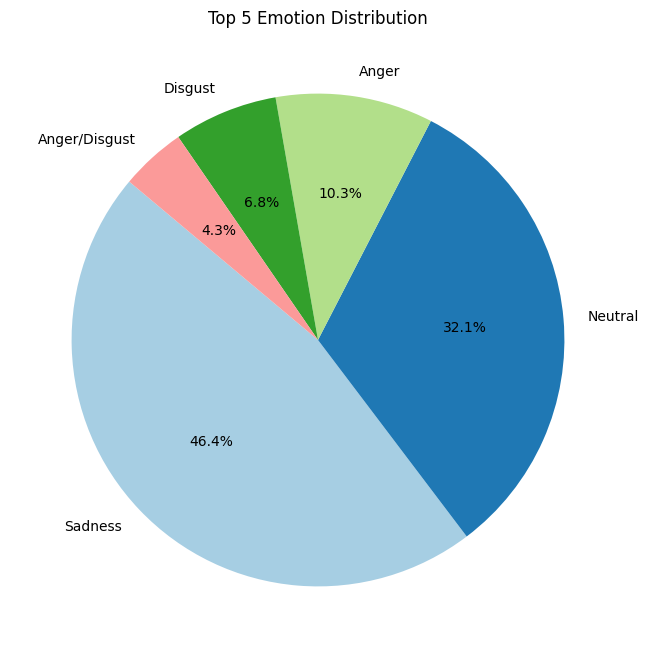

In [8]:
# Pie Chart for Top 5 Emotions
emotion_counts = data['emotion'].value_counts().nlargest(5)
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 5 Emotion Distribution")
plt.show()

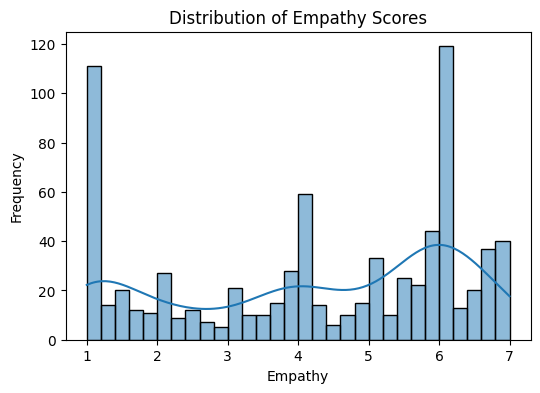

In [9]:
# Label distributions
plt.figure(figsize=(6, 4))
sns.histplot(data['empathy'], bins=30, kde=True)
plt.title("Distribution of Empathy Scores")
plt.xlabel("Empathy")
plt.ylabel("Frequency")
plt.show()

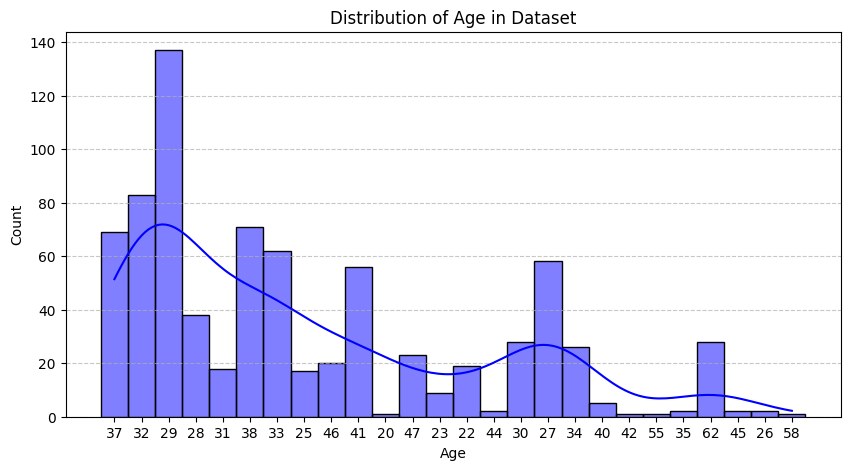

In [10]:
# Histogram of Age
plt.figure(figsize=(10, 5))
sns.histplot(data['age'], bins=20, kde=True, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age in Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

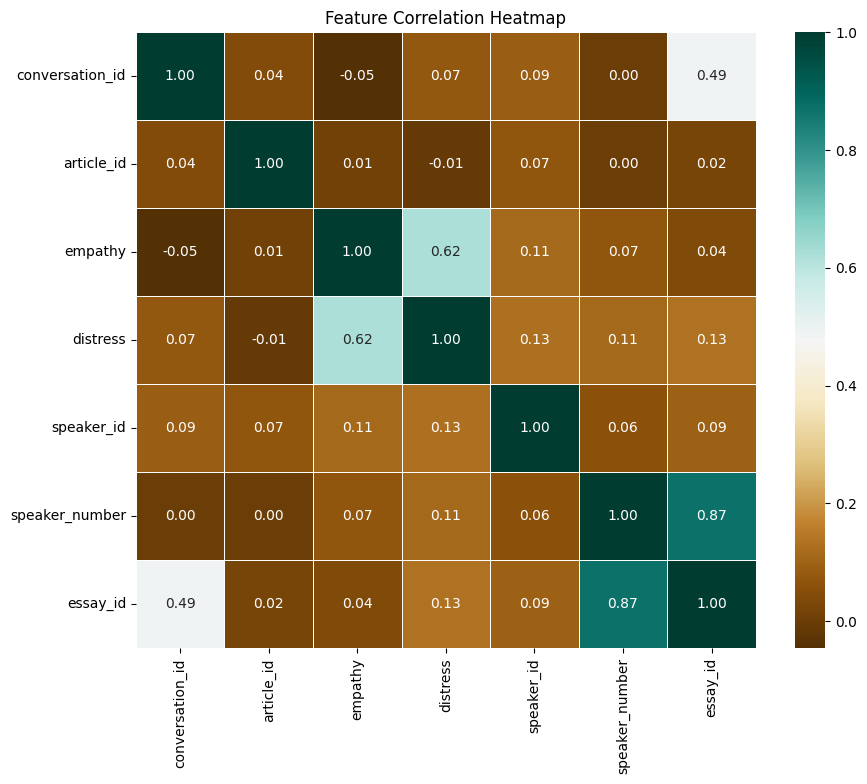

In [11]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
numeric_df = data.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='BrBG', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [12]:
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


data["cleaned_essay"] = data["essay"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Convert emotions into binary labels (1 for Anger, Neutral, Sadness; 0 for others)
binary_emotions = ["Anger", "Neutral", "Sadness", "Joy", "Hope", "Disgust", "Fear", "Surprise"]
data['binary_emotion'] = data['emotion'].apply(lambda x: 1 if x in binary_emotions else 0)

In [14]:
# Select text and labels (Modify based on specific task)
X = data['cleaned_essay'].astype(str)
y = data['binary_emotion'].astype(str)  # Change this if using different labels

In [15]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [16]:
# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [17]:
# Padding
max_length = 300  # Adjust based on dataset analysis
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [19]:
# Define BiLSTM Model
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=20000, output_dim=128)(input_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
global_avg_layer = GlobalAveragePooling1D()(attention_layer)
dropout_layer = Dropout(0.3)(global_avg_layer)
dense_layer = Dense(64, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.3)(dense_layer)
output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history_lstm = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc_LSTM = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc_LSTM:.4f}')


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step - accuracy: 0.7614 - loss: 0.5603 - val_accuracy: 0.8141 - val_loss: 0.4909
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.8141 - loss: 0.4916 - val_accuracy: 0.8141 - val_loss: 0.4832
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.8129 - loss: 0.5039 - val_accuracy: 0.8141 - val_loss: 0.4826
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 549ms/step - accuracy: 0.8146 - loss: 0.4919 - val_accuracy: 0.8141 - val_loss: 0.4819
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.8027 - loss: 0.5104 - val_accuracy: 0.8141 - val_loss: 0.4817
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 571ms/step - accuracy: 0.8123 - loss: 0.4883 - val_accuracy: 0.8141 - val_loss: 0.4790
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.8102 - loss: 0.4823 - val_accuracy: 0.8141 - val_loss: 0.4761
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 531ms/step - accuracy: 0.8071 - loss: 0.4708 - val_accu

In [20]:
# Define CNN Model
input_layer_cnn = Input(shape=(max_length,))
embedding_layer_cnn = Embedding(input_dim=20000, output_dim=128)(input_layer_cnn)
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer_cnn)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
dense_layer_cnn = Dense(64, activation='relu')(pooling_layer)
dropout_layer_cnn = Dropout(0.3)(dense_layer_cnn)
output_layer_cnn = Dense(len(np.unique(y)), activation='softmax')(dropout_layer_cnn)

model_cnn = Model(inputs=input_layer_cnn, outputs=output_layer_cnn)
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN Model
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate CNN Model
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc_cnn:.4f}')

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7871 - loss: 0.5953 - val_accuracy: 0.8141 - val_loss: 0.5037
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8065 - loss: 0.5016 - val_accuracy: 0.8141 - val_loss: 0.4847
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.8514 - loss: 0.3907 - val_accuracy: 0.8141 - val_loss: 0.4832
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8099 - loss: 0.3703 - val_accuracy: 0.8141 - val_loss: 0.4781
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8410 - loss: 0.2530 - val_accuracy: 0.8141 - val_loss: 0.4802
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9952 - loss: 0.1109 - val_accuracy: 0.8141 - val_loss: 0.5225
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9946 - loss: 0.0458 - val_accuracy: 0.8141 - val_loss: 0.5839
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.

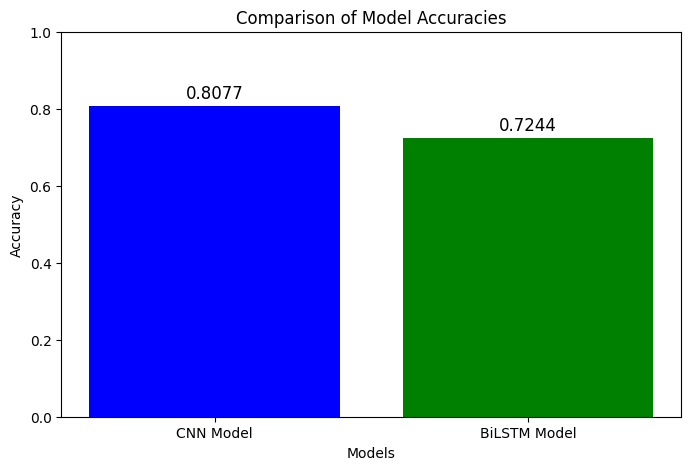

In [21]:
# Plot accuracy comparison
models = ['CNN Model', 'BiLSTM Model']
accuracies = [test_acc_cnn, test_acc_LSTM]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
plt.show()

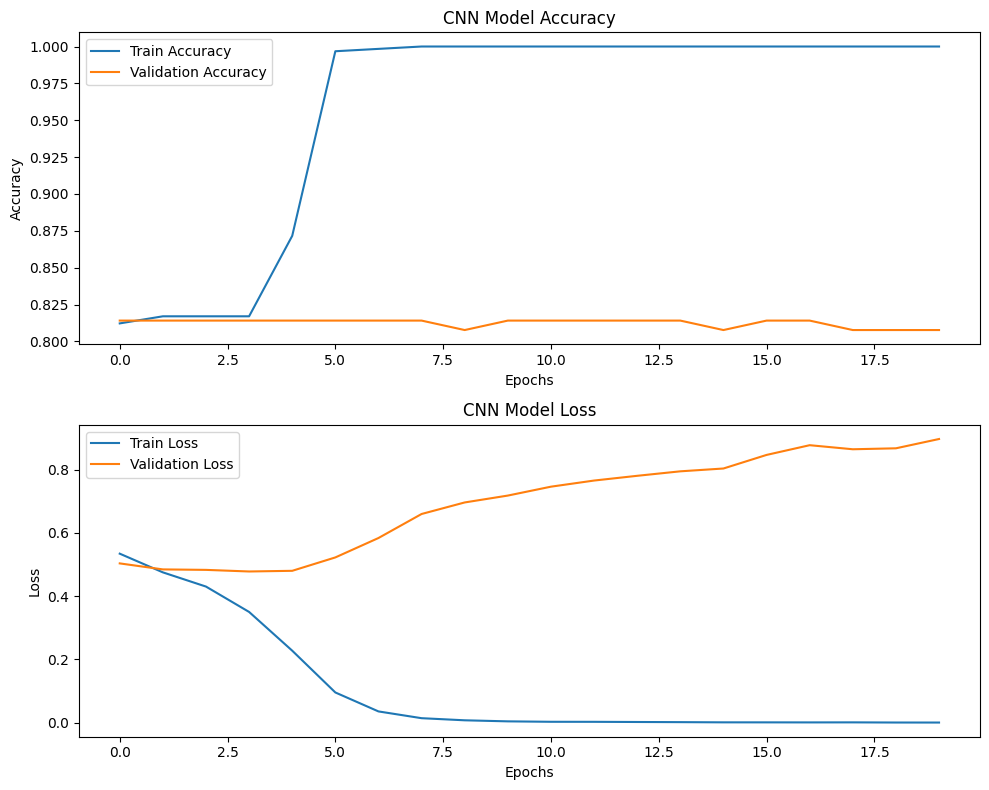

In [22]:
# Plot training loss and accuracy for CNN model
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(history_cnn.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('CNN Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history_cnn.history['loss'], label='Train Loss')
axs[1].plot(history_cnn.history['val_loss'], label='Validation Loss')
axs[1].set_title('CNN Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

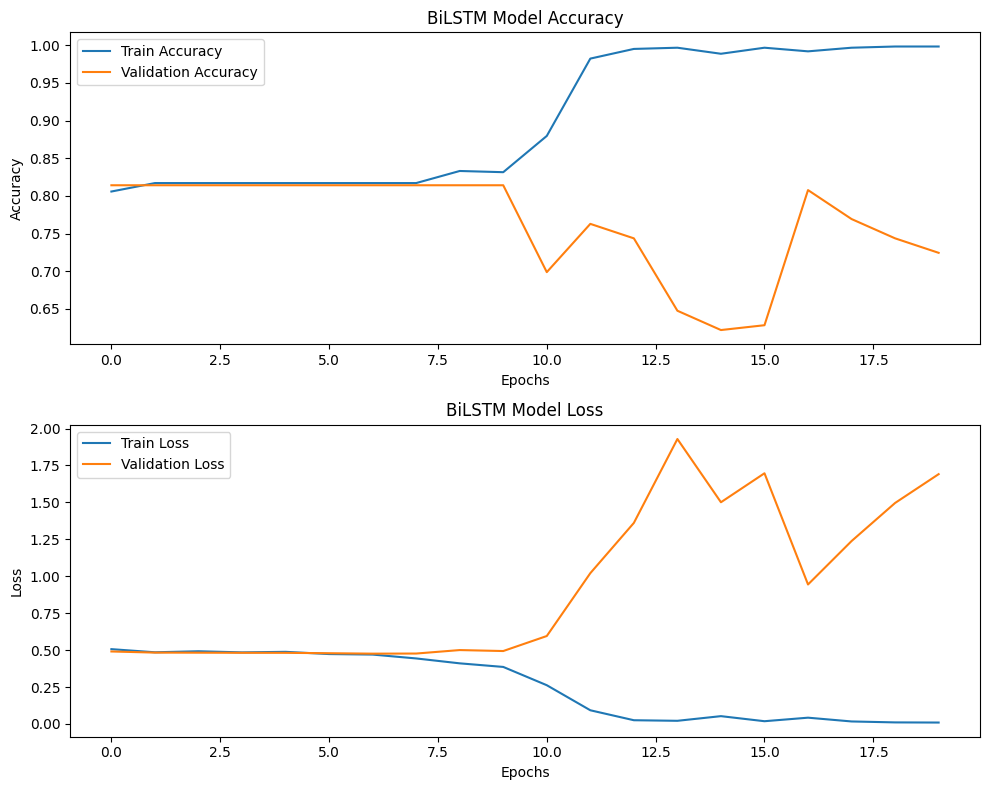

In [23]:
# Plot training loss and accuracy for BiLSTM model
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(history_lstm.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('BiLSTM Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history_lstm.history['loss'], label='Train Loss')
axs[1].plot(history_lstm.history['val_loss'], label='Validation Loss')
axs[1].set_title('BiLSTM Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()